In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import max_error
import seaborn as sns
from keras.callbacks import History 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit 
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Bidirectional
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.
/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jorge/anaconda3/envs/machinelearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
path = os.getcwd()
folder = path+"/dataset/ts_jorge_MW8.6/"
print(folder)

/home/jorge/tsunami-warning/dataset/ts_jorge_MW8.6/


In [3]:
df = pd.read_json(folder+'DataFrame_boyas79_80viña.json') # cargar dataframe

In [4]:
index = pd.date_range('25/8/2020', periods=len(df), freq='S')
Datetime = pd.DataFrame({'Datetime':index})

In [5]:
df = pd.concat([Datetime, df], axis=1,)

In [6]:
df.head()

,Datetime,boyas79_ts002,inu_vina80_ts002,boyas79_ts034,inu_vina80_ts034,boyas79_ts035,inu_vina80_ts035,boyas79_ts043,inu_vina80_ts043,boyas79_ts050,...,boyas79_s_026,inu_vina80_s_026,boyas79_s_027,inu_vina80_s_027,boyas79_s_031,inu_vina80_s_031,boyas79_s_032,inu_vina80_s_032,boyas79_s_033,inu_vina80_s_033
0,2020-08-25 00:00:00,0.000000,0,0.000000,0,0.000000e+00,0.0,0.000000,0,0.000000,...,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0
1,2020-08-25 00:00:01,-0.000002,0,0.000017,0,-7.395000e-07,0.0,-0.000005,0,0.000004,...,0.000016,0,0.000007,0,0.000010,0,-0.000010,0,0.000012,0
2,2020-08-25 00:00:02,-0.000005,0,0.000037,0,-1.534100e-06,0.0,-0.000011,0,0.000009,...,0.000036,0,0.000016,0,0.000023,0,-0.000023,0,0.000026,0
3,2020-08-25 00:00:03,-0.000010,0,0.000066,0,-2.505600e-06,0.0,-0.000019,0,0.000017,...,0.000063,0,0.000028,0,0.000041,0,-0.000042,0,0.000047,0
4,2020-08-25 00:00:04,-0.000023,0,0.000149,0,-5.265200e-06,0.0,-0.000043,0,0.000038,...,0.000143,0,0.000063,0,0.000093,0,-0.000097,0,0.000106,0


Text(0, 0.5, 'Altura de ola [m]')

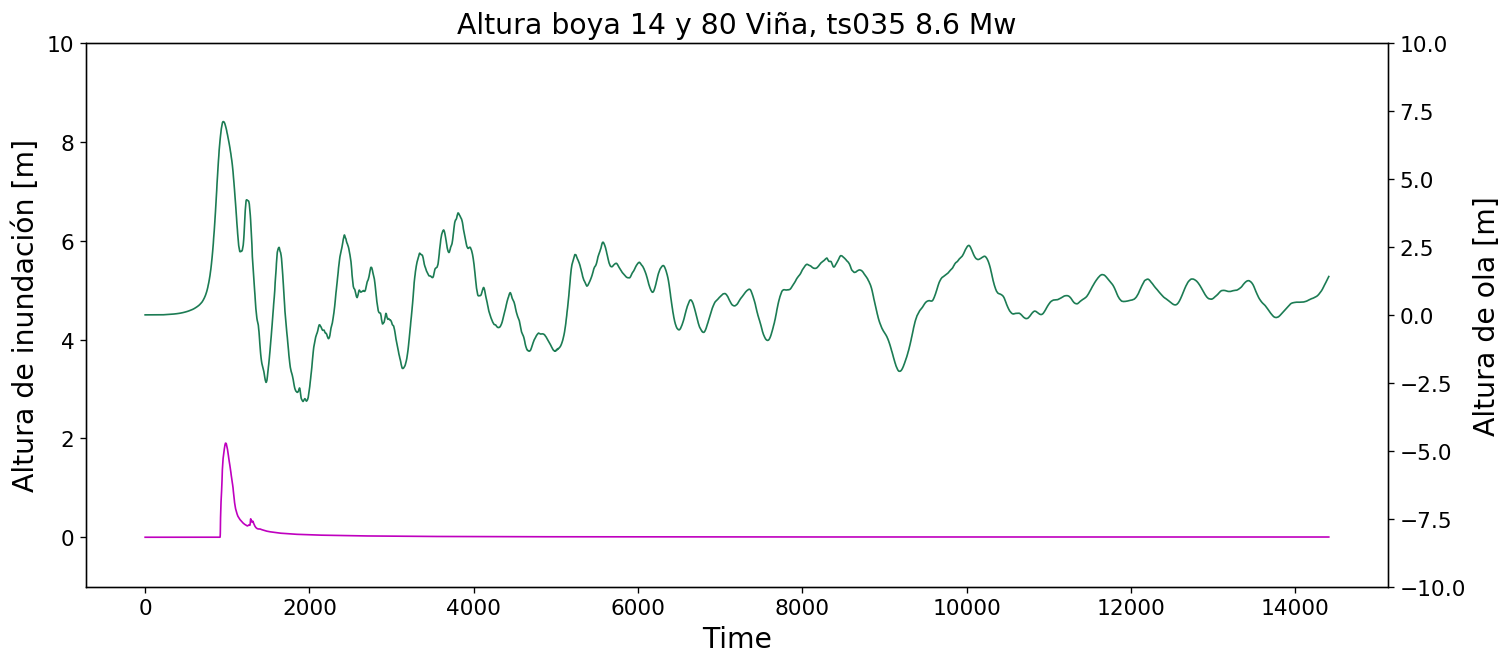

In [7]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 80 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df['inu_vina80_ts035'], color='m', linewidth=1.0)
plt.ylim(-1,10)
plt.twinx()
plt.plot(df['boyas79_ts035'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)

In [8]:
df = df.loc[0:1799]

In [9]:
df.describe()

,boyas79_ts002,inu_vina80_ts002,boyas79_ts034,inu_vina80_ts034,boyas79_ts035,inu_vina80_ts035,boyas79_ts043,inu_vina80_ts043,boyas79_ts050,inu_vina80_ts050,...,boyas79_s_026,inu_vina80_s_026,boyas79_s_027,inu_vina80_s_027,boyas79_s_031,inu_vina80_s_031,boyas79_s_032,inu_vina80_s_032,boyas79_s_033,inu_vina80_s_033
count,1800.000000,1800.0,1800.000000,1800.0,1800.000000,1800.000000,1800.000000,1800.0,1800.000000,1800.0,...,1800.000000,1800.0,1800.000000,1800.0,1800.000000,1800.0,1800.000000,1800.0,1800.000000,1800.0
mean,-0.439738,0.0,-0.140431,0.0,1.277882,0.207875,-1.032331,0.0,-0.188085,0.0,...,-0.115044,0.0,0.403564,0.0,-0.045907,0.0,0.055583,0.0,-0.376196,0.0
std,0.608827,0.0,1.481587,0.0,2.372399,0.423211,1.198723,0.0,0.516642,0.0,...,1.042747,0.0,0.627001,0.0,0.745294,0.0,1.347322,0.0,0.975594,0.0
min,-1.759183,0.0,-4.129583,0.0,-2.483465,0.000000,-3.720523,0.0,-1.555848,0.0,...,-2.571706,0.0,-0.673922,0.0,-1.679436,0.0,-2.147708,0.0,-1.957115,0.0
25%,-0.900343,0.0,-1.007310,0.0,-0.000076,0.000000,-1.919356,0.0,-0.478486,0.0,...,-0.772636,0.0,0.067613,0.0,-0.584033,0.0,-0.636872,0.0,-1.305304,0.0
50%,-0.221310,0.0,0.204962,0.0,0.217124,0.000000,-0.543173,0.0,0.024597,0.0,...,0.335304,0.0,0.256457,0.0,0.071270,0.0,-0.271082,0.0,0.005061,0.0
75%,-0.055451,0.0,0.867801,0.0,2.430115,0.173391,-0.167823,0.0,0.108189,0.0,...,0.461363,0.0,0.468113,0.0,0.506730,0.0,0.971604,0.0,0.430625,0.0
max,0.613058,0.0,2.168482,0.0,7.112984,1.905331,1.231893,0.0,1.062584,0.0,...,1.396651,0.0,2.304038,0.0,1.171595,0.0,2.860675,0.0,1.148816,0.0


In [10]:
df = df.resample('S', on='Datetime').mean()

Text(0, 0.5, 'Altura de ola [m]')

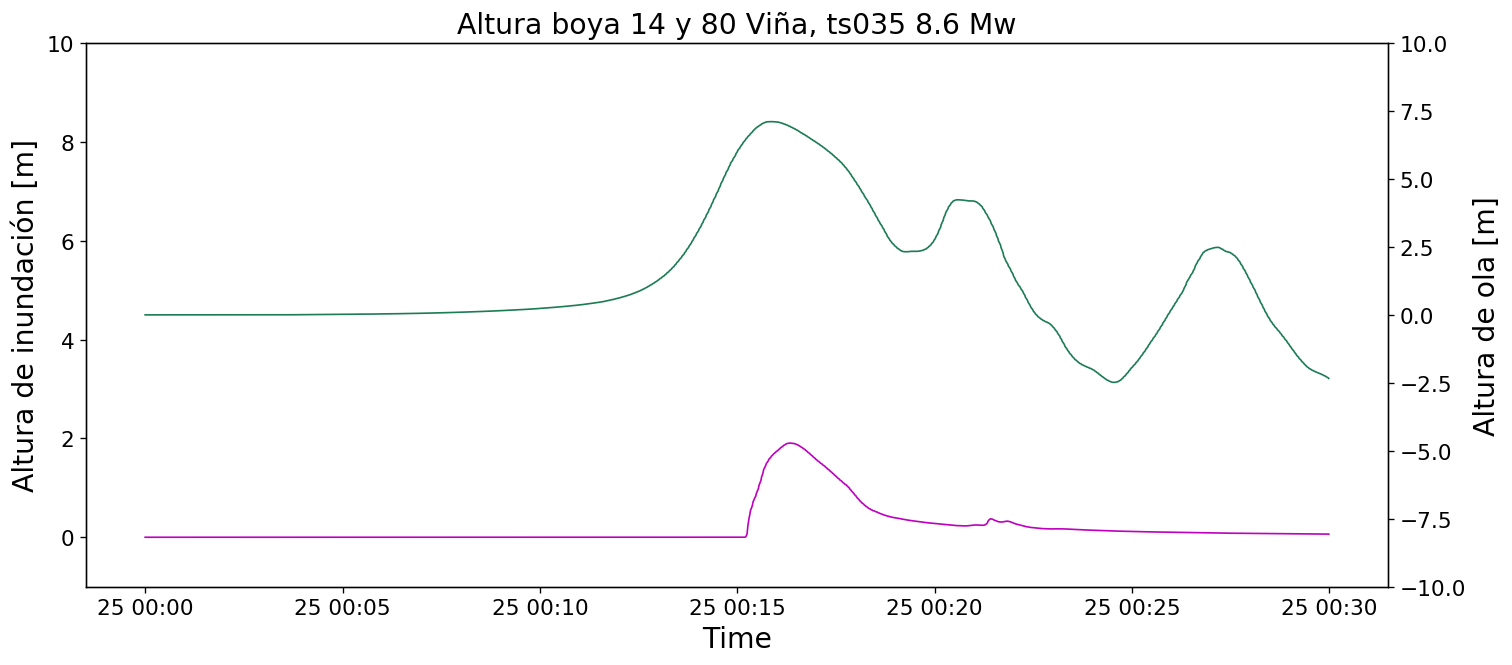

In [11]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 80 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df['inu_vina80_ts035'], color='m', linewidth=1.0)
plt.ylim(-1,10)
plt.twinx()
plt.plot(df['boyas79_ts035'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)


Text(0, 0.5, 'Altura de ola [m]')

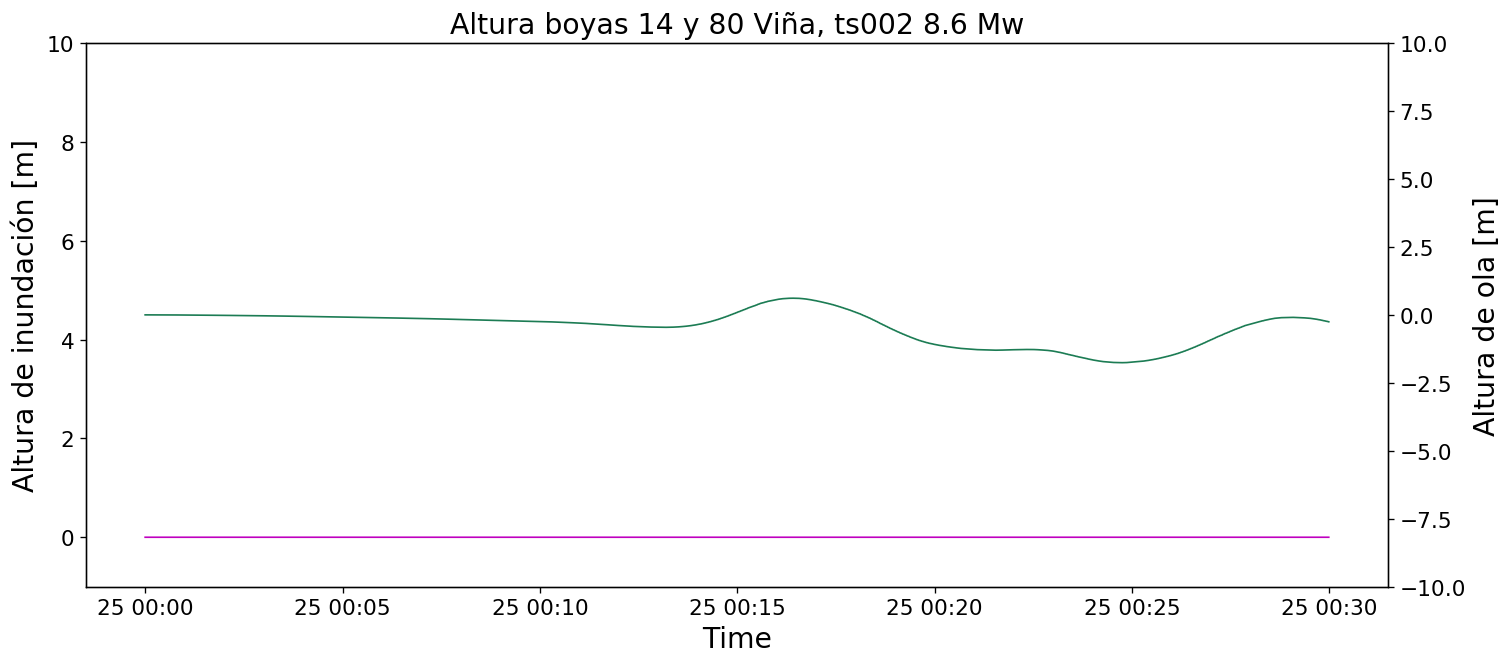

In [12]:
plt.figure(figsize=(14,6), dpi=120)
plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boyas 14 y 80 Viña, ts002 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df['inu_vina80_ts002'], color='m', linewidth=1.0)
plt.ylim(-1,10)
plt.twinx()
plt.plot(df['boyas79_ts002'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)

In [13]:
df = df.resample('T').mean()

In [14]:
df.describe()

,boyas79_ts002,inu_vina80_ts002,boyas79_ts034,inu_vina80_ts034,boyas79_ts035,inu_vina80_ts035,boyas79_ts043,inu_vina80_ts043,boyas79_ts050,inu_vina80_ts050,...,boyas79_s_026,inu_vina80_s_026,boyas79_s_027,inu_vina80_s_027,boyas79_s_031,inu_vina80_s_031,boyas79_s_032,inu_vina80_s_032,boyas79_s_033,inu_vina80_s_033
count,30.000000,30.0,30.000000,30.0,30.000000,30.000000,30.000000,30.0,30.000000,30.0,...,30.000000,30.0,30.000000,30.0,30.000000,30.0,30.000000,30.0,30.000000,30.0
mean,-0.439738,0.0,-0.140431,0.0,1.277882,0.207875,-1.032331,0.0,-0.188085,0.0,...,-0.115044,0.0,0.403564,0.0,-0.045907,0.0,0.055583,0.0,-0.376196,0.0
std,0.613423,0.0,1.482058,0.0,2.375391,0.410758,1.194011,0.0,0.517540,0.0,...,1.053347,0.0,0.624771,0.0,0.753228,0.0,1.356084,0.0,0.987897,0.0
min,-1.732048,0.0,-3.913410,0.0,-2.280775,0.000000,-3.636377,0.0,-1.453511,0.0,...,-2.539505,0.0,-0.609951,0.0,-1.572886,0.0,-2.096976,0.0,-1.937746,0.0
25%,-0.799367,0.0,-1.046005,0.0,0.000543,0.000000,-1.883690,0.0,-0.407625,0.0,...,-0.604771,0.0,0.062474,0.0,-0.579223,0.0,-0.533965,0.0,-1.230372,0.0
50%,-0.207004,0.0,0.194869,0.0,0.243968,0.033267,-0.538297,0.0,0.037732,0.0,...,0.337065,0.0,0.256139,0.0,0.066956,0.0,-0.249743,0.0,-0.015693,0.0
75%,-0.074625,0.0,0.922566,0.0,2.340582,0.193386,-0.182562,0.0,0.102221,0.0,...,0.444563,0.0,0.457234,0.0,0.473678,0.0,0.624467,0.0,0.414096,0.0
max,0.587529,0.0,1.854648,0.0,6.785077,1.802148,0.499495,0.0,0.761677,0.0,...,1.374232,0.0,2.168813,0.0,1.133133,0.0,2.826355,0.0,1.131198,0.0


Text(0, 0.5, 'Altura de ola [m]')

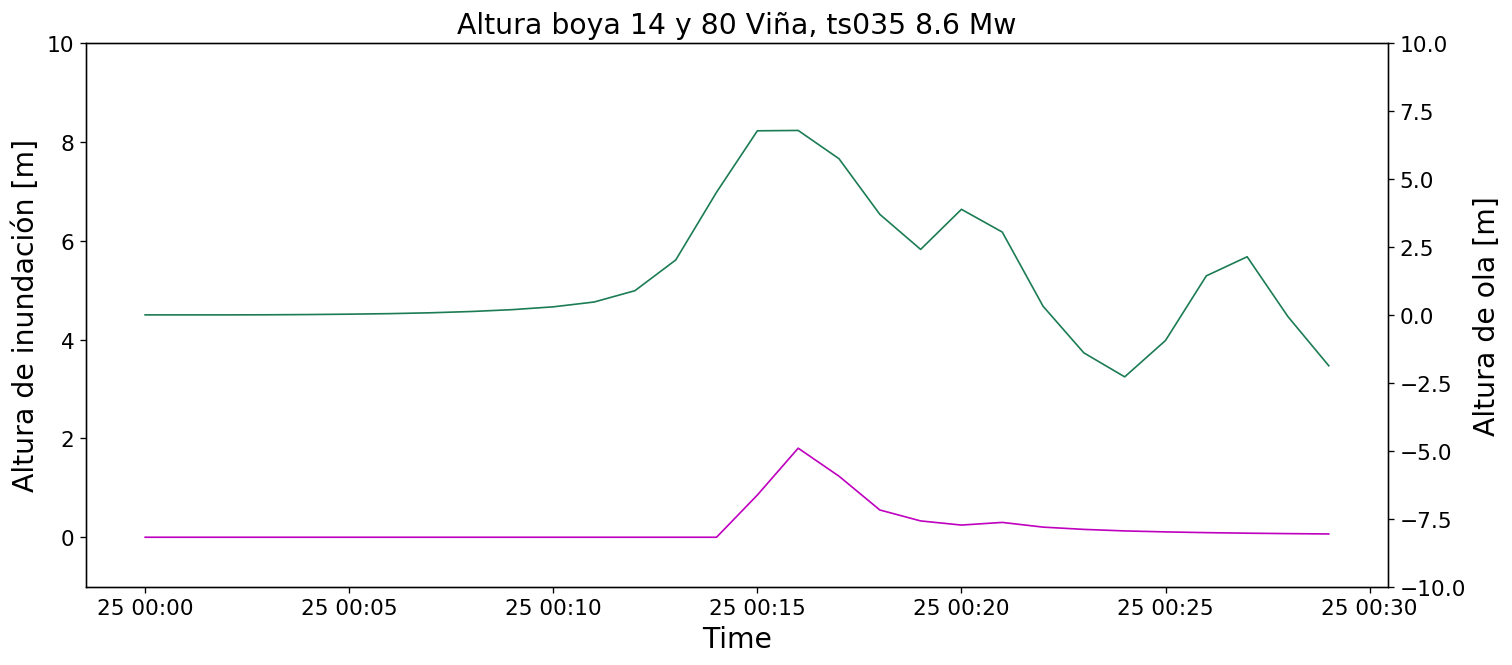

In [15]:
plt.figure(figsize=(14,6), dpi=120)

plt.ion()
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
plt.title('Altura boya 14 y 80 Viña, ts035 8.6 Mw',fontsize=17)
plt.xlabel('Time',fontsize=17)
plt.ylabel('Altura de inundación [m]',fontsize=17)
plt.plot(df['inu_vina80_ts035'], color='m', linewidth=1.0)
plt.ylim(-1,10)
plt.twinx()
plt.plot(df['boyas79_ts035'], color='#1C7C54', linewidth=1.0)
plt.ylim(-10,10)
ax = plt.gca()
#ax.invert_yaxis()
plt.ylabel('Altura de ola [m]',fontsize=17)


In [16]:
#data_pre_train, data_pre_temp = train_test_split(data, test_size= 0.5)
#data_pre_val, data_pre_test = train_test_split(data_pre_temp, test_size= 0.4)

#scaler = StandardScaler().fit(df)
#df= pd.DataFrame(scaler.transform(df),
#                                 columns=df.columns)


In [17]:
xtest = df.pop('boyas79_ts035') # asigna y quita columna
ytest = df.pop('inu_vina80_ts035') # asigna y quita columna

In [18]:
df = df.values.astype('float32')
xtest = xtest.values.astype('float32')
ytest = ytest.values.astype('float32')

In [19]:
# genera secuencias de entrada y salida

def split_sequence(df):
    X, y = list(), list()
    for time in range(0,df.shape[1],2):
        # se suma uno porque no considera el ultimo
        seq_x, seq_y = df[:,time], df[:,time+1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [20]:
trainX,trainY = split_sequence(df)
testX,testY = xtest,ytest

In [21]:
n_features = 1
n_steps = trainX.shape[1]
print('n_steps :',n_steps)

n_steps : 30


In [22]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))

In [23]:
trainX.shape

(96, 30, 1)

In [24]:
trainY.shape

(96, 30)

In [25]:
import time
epoch = 100
Xm = trainX
ym = trainY
tscv = TimeSeriesSplit(n_splits=5)
start = time.time()
# define model
hist = History()
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps))
#model.compile(optimizer=Adam(lr=0.006), loss='mse')
model.compile(optimizer=Adam(lr=0.006), loss='mse')
# fit model
for train, test in tscv.split(Xm):
    history = model.fit(Xm[train], ym[train],validation_data=(Xm[test], ym[test]), epochs=epoch, verbose=1
                        ,callbacks=[hist])
                        
#history=model.fit(trainX, trainY, epochs=epoch, verbose=1,callbacks=[hist])

end = time.time()

print('time execution',(end - start)/60)


Train on 16 samples, validate on 16 samples
Epoch 1/100
16/16 [==============================] - 2s 106ms/step - loss: 0.0228 - val_loss: 0.0387
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0171 - val_loss: 0.0391
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0202 - val_loss: 0.0384
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0396
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0164 - val_loss: 0.0394
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0168 - val_loss: 0.0386
Epoch 7/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0165 - val_loss: 0.0371
Epoch 8/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0156 - val_loss: 0.0349
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0144 - val_loss: 0.0327
Epoch 10/100
16/16 [==============================] - 0s 5ms/s

Epoch 79/100
16/16 [==============================] - 0s 5ms/step - loss: 2.1967e-04 - val_loss: 0.0332
Epoch 80/100
16/16 [==============================] - 0s 7ms/step - loss: 2.1315e-04 - val_loss: 0.0337
Epoch 81/100
16/16 [==============================] - 0s 7ms/step - loss: 1.9813e-04 - val_loss: 0.0342
Epoch 82/100
16/16 [==============================] - 0s 6ms/step - loss: 1.9791e-04 - val_loss: 0.0345
Epoch 83/100
16/16 [==============================] - 0s 5ms/step - loss: 1.9365e-04 - val_loss: 0.0348
Epoch 84/100
16/16 [==============================] - 0s 6ms/step - loss: 1.8109e-04 - val_loss: 0.0350
Epoch 85/100
16/16 [==============================] - 0s 5ms/step - loss: 1.7860e-04 - val_loss: 0.0354
Epoch 86/100
16/16 [==============================] - 0s 5ms/step - loss: 1.7162e-04 - val_loss: 0.0360
Epoch 87/100
16/16 [==============================] - 0s 5ms/step - loss: 1.6074e-04 - val_loss: 0.0364
Epoch 88/100
16/16 [==============================] - 0s 5ms/ste

Epoch 59/100
32/32 [==============================] - 0s 3ms/step - loss: 1.7005e-04 - val_loss: 0.0049
Epoch 60/100
32/32 [==============================] - 0s 3ms/step - loss: 1.6726e-04 - val_loss: 0.0049
Epoch 61/100
32/32 [==============================] - 0s 3ms/step - loss: 1.6672e-04 - val_loss: 0.0049
Epoch 62/100
32/32 [==============================] - 0s 3ms/step - loss: 1.5734e-04 - val_loss: 0.0049
Epoch 63/100
32/32 [==============================] - 0s 3ms/step - loss: 1.6126e-04 - val_loss: 0.0049
Epoch 64/100
32/32 [==============================] - 0s 3ms/step - loss: 1.5832e-04 - val_loss: 0.0049
Epoch 65/100
32/32 [==============================] - 0s 3ms/step - loss: 1.4990e-04 - val_loss: 0.0049
Epoch 66/100
32/32 [==============================] - 0s 3ms/step - loss: 1.5016e-04 - val_loss: 0.0049
Epoch 67/100
32/32 [==============================] - 0s 3ms/step - loss: 1.4482e-04 - val_loss: 0.0049
Epoch 68/100
32/32 [==============================] - 0s 3ms/ste

48/48 [==============================] - 0s 3ms/step - loss: 2.4941e-04 - val_loss: 3.6811e-04
Epoch 38/100
48/48 [==============================] - 0s 3ms/step - loss: 3.0355e-04 - val_loss: 3.6636e-04
Epoch 39/100
48/48 [==============================] - 0s 3ms/step - loss: 3.6854e-04 - val_loss: 3.6000e-04
Epoch 40/100
48/48 [==============================] - 0s 3ms/step - loss: 2.1958e-04 - val_loss: 3.6108e-04
Epoch 41/100
48/48 [==============================] - 0s 3ms/step - loss: 2.2977e-04 - val_loss: 3.5947e-04
Epoch 42/100
48/48 [==============================] - 0s 4ms/step - loss: 2.0457e-04 - val_loss: 3.5517e-04
Epoch 43/100
48/48 [==============================] - 0s 3ms/step - loss: 2.0083e-04 - val_loss: 3.5607e-04
Epoch 44/100
48/48 [==============================] - 0s 3ms/step - loss: 1.9959e-04 - val_loss: 3.6160e-04
Epoch 45/100
48/48 [==============================] - 0s 3ms/step - loss: 2.0332e-04 - val_loss: 3.6415e-04
Epoch 46/100
48/48 [=====================

64/64 [==============================] - 0s 3ms/step - loss: 1.4106e-04 - val_loss: 0.0153
Epoch 14/100
64/64 [==============================] - 0s 2ms/step - loss: 1.4154e-04 - val_loss: 0.0153
Epoch 15/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4061e-04 - val_loss: 0.0153
Epoch 16/100
64/64 [==============================] - 0s 3ms/step - loss: 1.4034e-04 - val_loss: 0.0153
Epoch 17/100
64/64 [==============================] - 0s 3ms/step - loss: 1.3904e-04 - val_loss: 0.0153
Epoch 18/100
64/64 [==============================] - 0s 3ms/step - loss: 1.3841e-04 - val_loss: 0.0153
Epoch 19/100
64/64 [==============================] - 0s 3ms/step - loss: 1.3798e-04 - val_loss: 0.0153
Epoch 20/100
64/64 [==============================] - 0s 3ms/step - loss: 1.3707e-04 - val_loss: 0.0153
Epoch 21/100
64/64 [==============================] - 0s 3ms/step - loss: 1.3650e-04 - val_loss: 0.0153
Epoch 22/100
64/64 [==============================] - 0s 3ms/step - loss: 1.3

Epoch 92/100
64/64 [==============================] - 0s 3ms/step - loss: 1.0584e-04 - val_loss: 0.0159
Epoch 93/100
64/64 [==============================] - 0s 3ms/step - loss: 1.0550e-04 - val_loss: 0.0158
Epoch 94/100
64/64 [==============================] - 0s 3ms/step - loss: 1.0494e-04 - val_loss: 0.0158
Epoch 95/100
64/64 [==============================] - 0s 3ms/step - loss: 1.0588e-04 - val_loss: 0.0159
Epoch 96/100
64/64 [==============================] - 0s 3ms/step - loss: 1.0452e-04 - val_loss: 0.0159
Epoch 97/100
64/64 [==============================] - 0s 3ms/step - loss: 1.0710e-04 - val_loss: 0.0158
Epoch 98/100
64/64 [==============================] - 0s 2ms/step - loss: 1.0697e-04 - val_loss: 0.0159
Epoch 99/100
64/64 [==============================] - 0s 3ms/step - loss: 1.0465e-04 - val_loss: 0.0161
Epoch 100/100
64/64 [==============================] - 0s 3ms/step - loss: 1.1224e-04 - val_loss: 0.0158
Train on 80 samples, validate on 16 samples
Epoch 1/100
80/80 [

80/80 [==============================] - 0s 3ms/step - loss: 2.6143e-04 - val_loss: 3.2387e-04
Epoch 70/100
80/80 [==============================] - 0s 3ms/step - loss: 2.9728e-04 - val_loss: 1.8659e-04
Epoch 71/100
80/80 [==============================] - 0s 3ms/step - loss: 2.8401e-04 - val_loss: 1.8251e-04
Epoch 72/100
80/80 [==============================] - 0s 3ms/step - loss: 2.2010e-04 - val_loss: 2.8149e-04
Epoch 73/100
80/80 [==============================] - 0s 4ms/step - loss: 2.7310e-04 - val_loss: 2.0536e-04
Epoch 74/100
80/80 [==============================] - 0s 3ms/step - loss: 2.3354e-04 - val_loss: 1.7892e-04
Epoch 75/100
80/80 [==============================] - 0s 3ms/step - loss: 2.1852e-04 - val_loss: 2.0724e-04
Epoch 76/100
80/80 [==============================] - 0s 3ms/step - loss: 2.1294e-04 - val_loss: 1.8898e-04
Epoch 77/100
80/80 [==============================] - 0s 4ms/step - loss: 1.9041e-04 - val_loss: 2.5450e-04
Epoch 78/100
80/80 [=====================

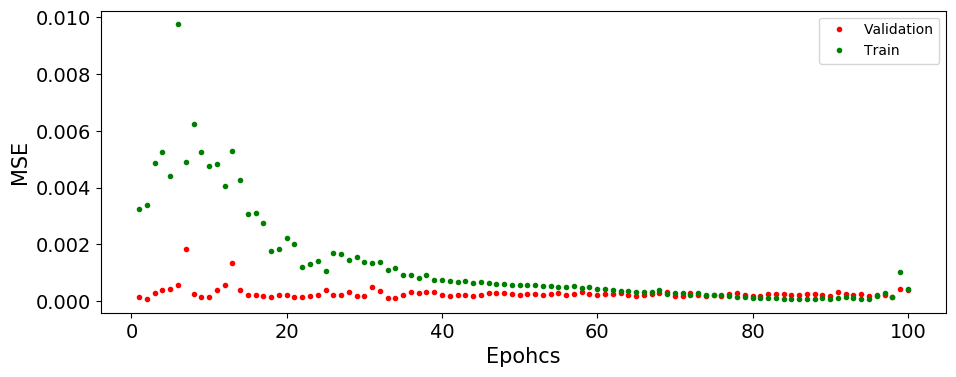

In [26]:
import matplotlib.pyplot as plt
a=np.linspace(1,epoch,epoch)
plt.figure(figsize=(24,4), dpi=100)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.subplot(1,2,1)
plt.plot(a,hist.history['val_loss'],'r.',label = 'Validation')
plt.plot(a,hist.history['loss'],'g.',label = 'Train')
plt.xlabel('Epohcs',fontsize=15)
plt.ylabel('MSE',fontsize=15)
plt.legend(loc='upper right')

In [27]:
trainX = df[:,50]
trainY = df[:,51]
trainX=trainX.reshape((1,n_steps,1))
testX=testX.reshape((1,n_steps,1))

In [28]:
trainPredict = (model.predict(trainX)).reshape(-1,1)
testPredict = (model.predict(testX)).reshape(-1,1)

In [29]:
# invert predictions
"""
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))
trainY = scaler.inverse_transform(trainY.reshape(-1,1))
testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
testY = scaler.inverse_transform(testY.reshape(-1,1))
"""

'\ntrainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))\ntrainY = scaler.inverse_transform(trainY.reshape(-1,1))\ntestPredict = scaler.inverse_transform(testPredict.reshape(-1,1))\ntestY = scaler.inverse_transform(testY.reshape(-1,1))\n'

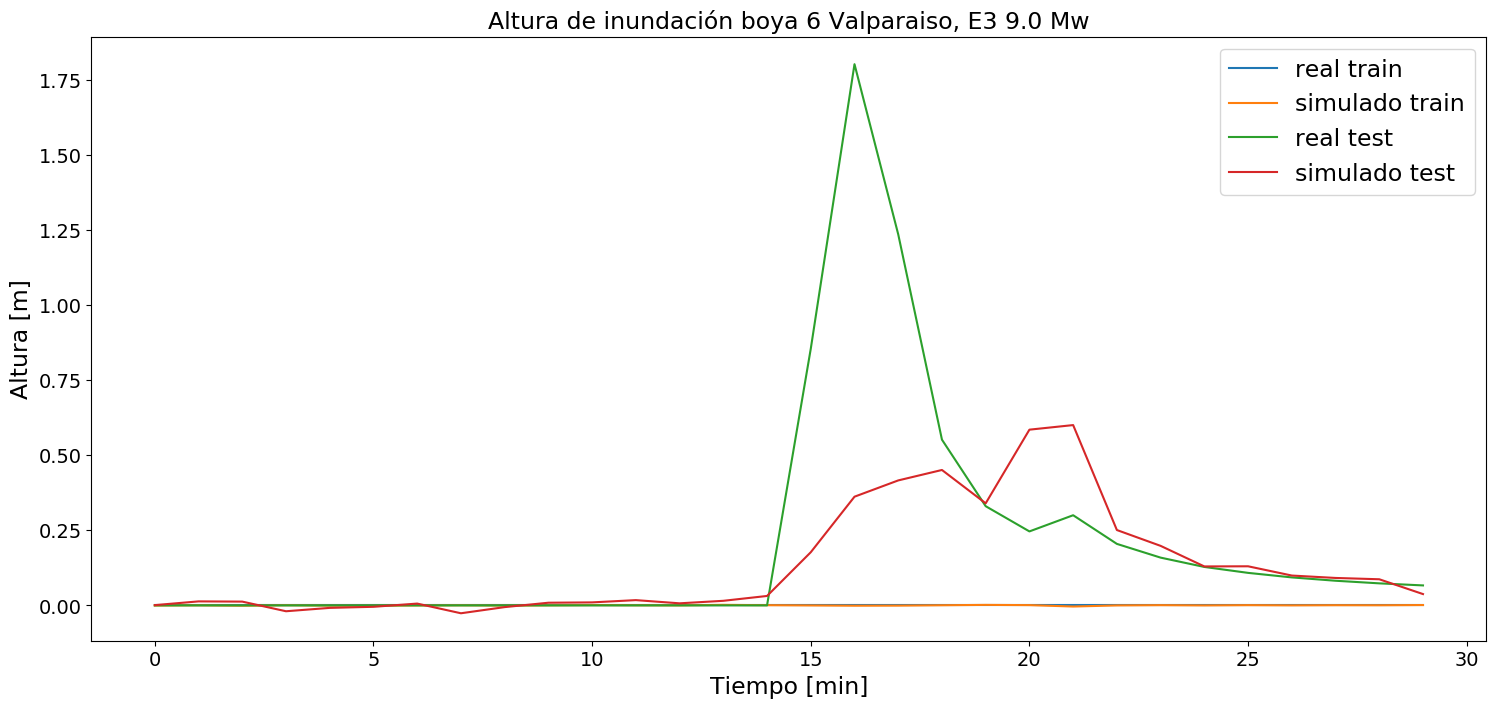

In [30]:
plt.figure(figsize=(18,8), dpi=100)

#plt.subplot(2,1,1)
plt.plot(trainY,label = 'real train')
plt.plot(trainPredict, label = 'simulado train')
plt.plot(testY,label = 'real test')
plt.plot(testPredict, label = 'simulado test')
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=17)
plt.title('Altura de inundación boya 6 Valparaiso, E3 9.0 Mw',fontsize=17)
plt.ylabel('Altura [m]',fontsize=17)
plt.xlabel('Tiempo [min]',fontsize=17)
plt.legend(loc='upper right',fontsize=17)

#plt.subplot(2,1,2)
#plt.plot(testY,label = 'real test')
#plt.plot(testPredict, label = 'simulado test')
#plt.rc('xtick', labelsize=17) 
#plt.rc('ytick', labelsize=17)
#plt.title('Altura de inundación boya 6 Valparaiso, E3 8.5 Mw',fontsize=17)
#plt.ylabel('Altura [m]',fontsize=17)
#plt.xlabel('Tiempo [s]',fontsize=17)
#plt.legend(loc='upper right',fontsize=17)

In [31]:
1800/90

20.0